# Bank Marketing Classification
*By Jiayin Ma*
<br>*February 2018*

____________________________________________________________________________________________________

## Content

### 1. Objectives

### 2. Exploratory Data Analysis
* 2.1 Import Libraries
* 2.2 Data Overview
* 2.3 Data Preparation
* 2.4 Visualisations and Statistical Summaries

### 3. Modeling
* 2.1 Get Train and Test Dataset
* 2.2 Models
* 2.3 Features selection

### 4. Summary

_______________________________________________________________________________________________________

# 1. Objectives

To predict if the client will subscribe (yes/no) a term deposit.

# 2. Exploratory Data Analysis

### 2.1 Import Libraries

In [2]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Handle table-like data and matrices
import numpy as np
import pandas as pd

# Modelling Algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.feature_extraction.text import CountVectorizer

# Modelling Helpers
from sklearn.preprocessing import Imputer , Normalizer , scale
from sklearn.cross_validation import train_test_split , StratifiedKFold
from sklearn.feature_selection import RFECV

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Configure visualisations
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 8, 6

/Users/carlicema/Documents/My_Studio/Anaconda/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### 2.2 Data Overview

In [3]:
df = pd.read_csv('bank-additional/bank.csv')
df.head(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [4]:
# check missing value
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
age          11162 non-null int64
job          11162 non-null object
marital      11162 non-null object
education    11162 non-null object
default      11162 non-null object
balance      11162 non-null int64
housing      11162 non-null object
loan         11162 non-null object
contact      11162 non-null object
day          11162 non-null int64
month        11162 non-null object
duration     11162 non-null int64
campaign     11162 non-null int64
pdays        11162 non-null int64
previous     11162 non-null int64
poutcome     11162 non-null object
deposit      11162 non-null object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB


**No missing value in the dataset.**

### What are the features?
<br>There are 2 categories of data: client information, client relations.

![picture1](https://user-images.githubusercontent.com/33208955/38591425-7f35253c-3ceb-11e8-974e-a30d622a7426.png)

### How many people subcribed the term deposit?

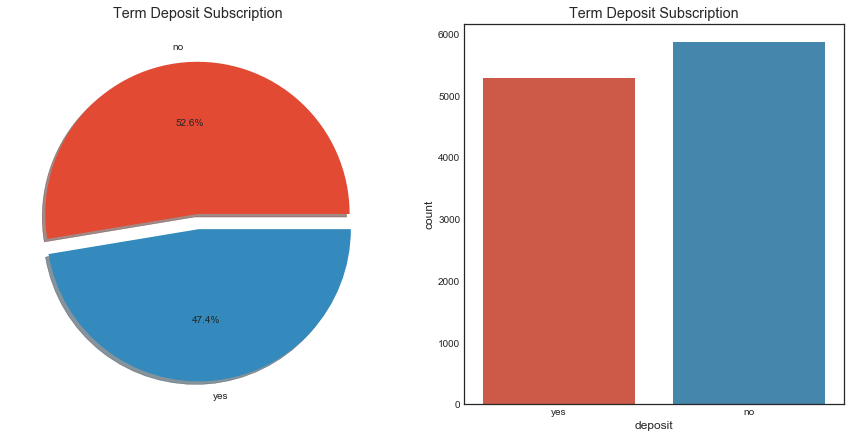

no     5873
yes    5289
Name: deposit, dtype: int64


In [5]:
f,ax=plt.subplots(1,2,figsize=(15,7))
df['deposit'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Term Deposit Subscription')
ax[0].set_ylabel('')
sns.countplot('deposit',data=df,ax=ax[1])
ax[1].set_title('Term Deposit Subscription')
plt.show()

print (df['deposit'].value_counts())

**From the pie chart and the column chart below, the results of the calls are nearly even, with nearly 52.6% “No” and nearly 47.4% “Yes”. Therefore, the dataset is balanced.**

### 2.3 Data Preparation

In [6]:
# check "unknown" value for the categorical features

print (df['job'].value_counts())
print ('-----------------------------')
print (df['marital'].value_counts())
print ('-----------------------------')
print (df['education'].value_counts())
print ('-----------------------------')
print (df['default'].value_counts())
print ('-----------------------------')
print (df['housing'].value_counts())
print ('-----------------------------')
print (df['loan'].value_counts())
print ('-----------------------------')
print (df['contact'].value_counts())
print ('-----------------------------')
print (df['month'].value_counts())
print ('-----------------------------')
print (df['day'].value_counts())
print ('-----------------------------')
print (df['poutcome'].value_counts())
print ('-----------------------------')
print (df['deposit'].value_counts())

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64
-----------------------------
married     6351
single      3518
divorced    1293
Name: marital, dtype: int64
-----------------------------
secondary    5476
tertiary     3689
primary      1500
unknown       497
Name: education, dtype: int64
-----------------------------
no     10994
yes      168
Name: default, dtype: int64
-----------------------------
no     5881
yes    5281
Name: housing, dtype: int64
-----------------------------
no     9702
yes    1460
Name: loan, dtype: int64
-----------------------------
cellular     8042
unknown      2346
telephone     774
Name: contact, dtype: int64
-----------------------------
may    2824
aug    1519
jul    1514
jun    1222
nov     943
apr     923
feb     776


**Dropped "poutcome" since it has a large proportion (86%) of nonexistent values. **

### Get Dummies
Prepare the categorical data for data analysis.

In [7]:
# convert the categorical variables into dummy variables

# job
df_job_dum = pd.get_dummies(df['job'])
df_job_dum.columns = ['admin', 'blue_collar', 'enterpreneur', 'housemaid', 'management', 'retired', 'self_employed', 
                      'services', 'student', 'technician', 'unemployed', 'unknown']

# marital
df_marital_dum = pd.get_dummies(df['marital'])
df_marital_dum.columns = ['divorced', 'married', 'single']

# education
df['edu_copy'] = df['education']
df['edu_copy'].loc[df['edu_copy']=='illiterate'] = 'primary' # 1: primary and below primary education
df['edu_copy'].loc[df['edu_copy']=='basic.4y'] = 'primary'  
df['edu_copy'].loc[df['edu_copy']=='basic.6y'] = 'primary'
df['edu_copy'].loc[df['edu_copy']=='basic.9y'] = 'secondary'  # 2: secondary education
df['edu_copy'].loc[df['edu_copy']=='high.school'] = 'secondary'
df['edu_copy'].loc[df['edu_copy']=='professional.course'] = 'tertiary'  # 3: tertiary education
df['edu_copy'].loc[df['edu_copy']=='university.degree'] = 'tertiary'
df['edu_copy'].loc[df['edu_copy']=='unknown'] = 'unknown'   # 4: unknown
df_edu_dum = pd.get_dummies(df['edu_copy'])
df_edu_dum.columns = ['primary_edu', 'secondary_edu', 'tertiary_edu', 'unk_edu']

# default
df_default_dum = pd.get_dummies(df['default'])
df_default_dum.columns = ['no_default', 'yes_default']

# housing
df_housing_dum = pd.get_dummies(df['housing'])
df_housing_dum.columns = ['no_housing', 'yes_housing']

# loan
df_loan_dum = pd.get_dummies(df['loan'])
df_loan_dum.columns = ['no_loan', 'yes_loan']

# contact
df['contact_dum'] = df['contact']
df['contact_dum'].loc[df['contact_dum']=="cellular"] = 1
df['contact_dum'].loc[df['contact_dum']=="telephone"] = 0
df['contact_dum'].loc[df['contact_dum']=="unknown"] = 2

# month
df_month_dum = pd.get_dummies(df['month'])

# day of week
df_week_dum = pd.get_dummies(df['day'])

# y
df['y_copy'] = df['deposit']
df['y_copy'].loc[df['y_copy']=="yes"] = 1
df['y_copy'].loc[df['y_copy']=="no"] = 0


df_join = df.join(df_job_dum)
df_join = df_join.join(df_marital_dum)
df_join = df_join.join(df_edu_dum)
df_join = df_join.join(df_default_dum)
df_join = df_join.join(df_housing_dum)
df_join = df_join.join(df_loan_dum)
df_join = df_join.join(df_month_dum)
df_join = df_join.join(df_week_dum)
df_join.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,...,22,23,24,25,26,27,28,29,30,31
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,...,0,0,0,0,0,0,0,0,0,0
1,56,admin.,married,secondary,no,45,no,no,unknown,5,...,0,0,0,0,0,0,0,0,0,0
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,...,0,0,0,0,0,0,0,0,0,0
3,55,services,married,secondary,no,2476,yes,no,unknown,5,...,0,0,0,0,0,0,0,0,0,0
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,...,0,0,0,0,0,0,0,0,0,0


### 2.4 How is the relationship between features and target?

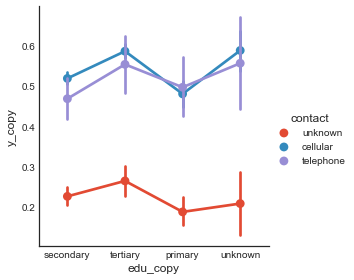

In [8]:
# education by contact method

sns.factorplot('edu_copy','y_copy',hue='contact',data=df_join)
plt.show()

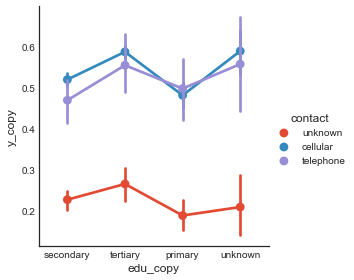

In [9]:
# education by contact method by weekdays

sns.factorplot('edu_copy','y_copy',hue='contact',data=df_join)
plt.show()

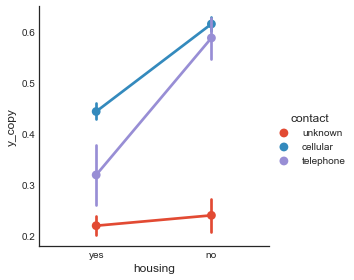

In [10]:
# housing by contact method by weekdays

sns.factorplot('housing','y_copy',hue='contact',data=df_join)
plt.show()

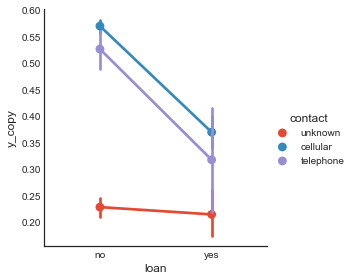

In [11]:
# loan by contact method by weekdays

sns.factorplot('loan','y_copy',hue='contact',data=df_join)
plt.show()

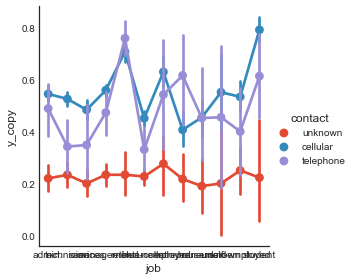

In [12]:
# job by contact method by weekdays

sns.factorplot('job','y_copy',hue='contact', data=df_join)
plt.show()

# 4. Modeling

### 4.1 Prepare train dataset and test dataset

In [13]:
# Drop the columns that will not be used in data analysis to simplify the dataset.

# Dropping "duration" is because the call duration is not known until the the call finished. 
# However, after the end of the call the result (deposit) is obviously known.
# Therefore, duration cannot used as a predicted feature.

df_new = df_join.drop(['poutcome', 'duration', 'job', 'marital', 'default', 'education', 'edu_copy', 'housing',
                      'loan', 'contact', 'month', 'day', 'deposit'], axis=1)
df_new.head(5)

,age,balance,campaign,pdays,previous,contact_dum,y_copy,admin,blue_collar,enterpreneur,...,22,23,24,25,26,27,28,29,30,31
0,59,2343,1,-1,0,2,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,56,45,1,-1,0,2,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,41,1270,1,-1,0,2,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,55,2476,1,-1,0,2,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,54,184,2,-1,0,2,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
X = df_new.drop('y_copy', axis=1)
y = df_new['y_copy']
print (X.shape)
print (y.shape)

(11162, 74)
(11162,)


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print (X_train.shape)
print (X_test.shape)
print (y_train.shape)
print (y_test.shape)

(7813, 74)
(3349, 74)
(7813,)
(3349,)


In [16]:
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

### 4.2 Models

#### Decision Tree

In [17]:
DecTree = tree.DecisionTreeClassifier()
DecTree.fit(X_train, y_train)
y_pred_tree = DecTree.predict(X_test)
sc1 = metrics.accuracy_score(y_pred_tree,y_test)
print ('accuracy score:', sc1)

accuracy score: 0.628247237981487


#### Random Forest

In [18]:
RandFor = RandomForestClassifier(max_depth = 3, min_samples_split=2, n_estimators = 50, random_state = 1)
RandFor.fit(X_train, y_train)
y_pred_ran = RandFor.predict(X_test)
sc2 = metrics.accuracy_score(y_pred_ran,y_test)
print ('accuracy score:', sc2)

accuracy score: 0.6733353239773067


#### Gradient Boost Classifier

In [19]:
gbmMod = GradientBoostingClassifier(max_depth = 3, n_estimators = 100, learning_rate = 0.05, random_state = 1)
gbmMod.fit(X_train,y_train)
y_pred_gbm = gbmMod.predict(X_test)
sc3 = metrics.accuracy_score(y_pred_gbm,y_test)
print ('accuracy score:', sc3)

accuracy score: 0.719020603165124


#### Logistic Regression

In [20]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
sc4 = metrics.accuracy_score(y_pred,y_test)
print ('accuracy score:', sc4)

accuracy score: 0.699014631233204


#### SVC

In [21]:
svmMod = SVC()
svmMod.fit(X_train,y_train)
y_pred = svmMod.predict(X_test)
sc5 = metrics.accuracy_score(y_pred,y_test)
print ('accuracy score:', sc5)

accuracy score: 0.6109286354135562


In [22]:
pd.DataFrame([['Decision Tree',sc1],['Random Forest',sc2], ['Gradient Boost',sc3], ['Logistic Regression',sc4], 
              ['Support Vector Machine',sc5]],  columns=['Model','Accuracy'])

,Model,Accuracy
0,Decision Tree,0.628247
1,Random Forest,0.673335
2,Gradient Boost,0.719021
3,Logistic Regression,0.699015
4,Support Vector Machine,0.610929


### 4.3 Feature Selection Using the Best Model

In [23]:
gbmMod = GradientBoostingClassifier(max_depth = 3, n_estimators = 100, learning_rate = 0.01, random_state = 1)
rfecv_gbm = RFECV(estimator=gbmMod, step=1, cv=StratifiedKFold(2),
              scoring='accuracy')
rfecv_gbm.fit(X_train, y_train)

print("Optimal number of features : %d" % rfecv_gbm.n_features_)

Optimal number of features : 11


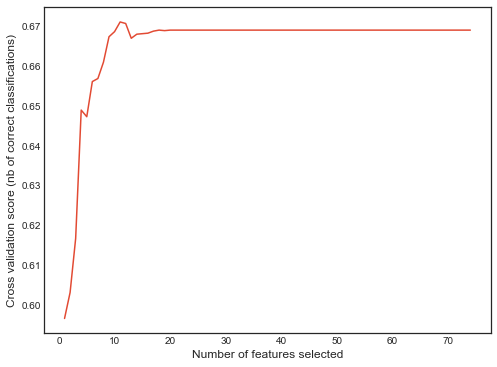

In [24]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv_gbm.grid_scores_) + 1), rfecv_gbm.grid_scores_)
plt.show()

MSE: 0.1904


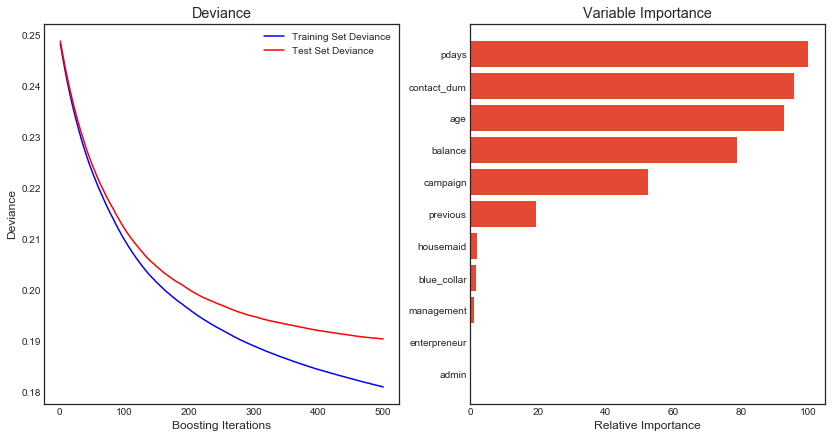

In [25]:
from sklearn import ensemble
from sklearn.metrics import mean_squared_error

# Fit regression model
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(X_train, y_train)
mse = mean_squared_error(y_test, clf.predict(X_test))
print("MSE: %.4f" % mse)

# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_test)):
    test_score[i] = clf.loss_(y_test, y_pred)
    

# Plot training deviance
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')


# Plot feature importance
feature_importance = clf.feature_importances_

# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance[0:11])
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns.values[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [26]:
# pick the top 11 important features as train data and test data

X_train_topfea = X_train[['age', 'pdays', 'campaign', 'previous', 'contact_dum', 'balance','housemaid',
                          'blue_collar', 'management', 'enterpreneur', 'admin']]
X_test_topfea = X_test[['age', 'pdays', 'campaign', 'previous', 'contact_dum', 'balance','housemaid',
                          'blue_collar', 'management', 'enterpreneur', 'admin']]

# modeling
gbmMod = GradientBoostingClassifier(max_depth =6, n_estimators = 100, learning_rate = 0.06, random_state = 1)
gbmMod.fit(X_train_topfea,y_train)
y_pred = gbmMod.predict(X_test_topfea)
sc3_topfea = metrics.accuracy_score(y_pred,y_test)
print ('GBM Score (top importance features):', sc3_topfea)

GBM Score (top importance features): 0.6745297103613018


# 4. Summary

* **Best-fit model: Gradient Boosting**


* **Optimal number of features: 11**


* **The top 11 important features:**
    
  **Client Relations:**
  <br>- Days since last contact
  <br>- Number of contact during campaign
  <br>- Previous contact
  <br>- Contact method
    
  **Client info:**
  <br>- Age
  <br>- Job: admin, blue_collar, management, retired, housemaid, enterpreneur
